In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize': (9, 6)})

In [2]:
users_data = pd.read_csv('users_data.csv', index_col=0)

In [3]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,True
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


In [4]:
events_data = pd.read_csv('event_data_train.csv')

In [5]:
events_data["date"] = pd.to_datetime(events_data.timestamp, unit='s')
events_data["day"] = events_data.date.dt.date

In [7]:
user_min_time = events_data.groupby('user_id', as_index=False).agg({'timestamp': 'min'}).rename({'timestamp': 'min_timestamp'}, axis=1)

In [8]:
users_data = users_data.merge(user_min_time, how='outer')

In [9]:
events_data['user_time'] = events_data.user_id.map(str) + '_' + events_data.timestamp.map(str)

In [10]:
learning_time_threshold = 2 * 24 * 60 * 60

In [11]:
user_learning_time_threshold = user_min_time.user_id.map(str) + '_' + (user_min_time.min_timestamp + learning_time_threshold).map(str)

In [12]:
user_min_time['user_learning_time_threshold'] = user_learning_time_threshold

In [13]:
events_data = events_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')

In [14]:
events_data_train = events_data[events_data.user_time <= events_data.user_learning_time_threshold]


In [15]:
events_data_train.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434513648
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434513648
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434513648
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434513648
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434513648


In [16]:
submissions_data = pd.read_csv('submissions_data_train.csv')

In [17]:
submissions_data["date"] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data["day"] = submissions_data.date.dt.date
submissions_data['user_time'] = submissions_data.user_id.map(str) + '_' + submissions_data.timestamp.map(str)
submissions_data = submissions_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')
submissions_data_train = submissions_data[submissions_data.user_time <= submissions_data.user_learning_time_threshold]
submissions_data_train.groupby('user_id').day.nunique().max()

3

In [18]:
X = submissions_data_train.groupby('user_id').day.nunique().to_frame().reset_index().rename(columns={'day': 'unique_days'})

In [19]:
steps_tried = submissions_data_train.groupby('user_id').step_id.nunique().to_frame().reset_index().rename(columns={'step_id': 'steps_tried'})

In [20]:
X = X.merge(steps_tried, on='user_id', how='outer')

In [21]:
X = X.merge(submissions_data.pivot_table(index='user_id', 
                       columns='submission_status', 
                       values='step_id', 
                       aggfunc='count', 
                       fill_value=0).reset_index())

In [22]:
X['correct_ratio'] = X.correct / (X.correct + X.wrong)

In [23]:
X = X.merge(events_data_train.pivot_table(index='user_id', 
                       columns='action', 
                       values='step_id', 
                       aggfunc='count', 
                       fill_value=0).reset_index(), how='outer')

In [24]:
X.user_id.nunique()

19234

In [25]:
X = X.fillna(0)

In [26]:
X = X.merge(users_data[['user_id', 'passed_course', 'is_gone_user']], how='outer')
X = X[~((X.is_gone_user == False) & (X.passed_course == False))]

In [27]:
y = X.passed_course

In [28]:
X = X.drop(['passed_course', 'is_gone_user'], axis=1)
X = X.set_index(X.user_id)
X = X.drop('user_id', axis=1)

In [31]:
X = X.drop(['unique_days', 'steps_tried', 'correct_ratio'], axis=1)

In [32]:
X.head(10)

,correct,wrong,discovered,passed,started_attempt,viewed
user_id,,,,,,
2,2.0,0.0,9,9,2,9
3,29.0,23.0,15,15,4,20
8,9.0,21.0,109,84,37,154
14,0.0,1.0,4,3,1,9
16,77.0,106.0,50,49,21,117
17,0.0,2.0,6,5,1,13
22,76.0,47.0,43,41,19,74
26,7.0,16.0,27,25,7,32
30,119.0,79.0,9,9,2,15


In [432]:
X = X.drop(['correct_ratio'], axis=1)

In [33]:
y = y.map(int)

In [34]:
y.head()

0    0
1    1
2    1
3    0
4    1
Name: passed_course, dtype: int64

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35)

In [37]:
clf_rf = RandomForestClassifier(n_estimators=100, n_jobs=2, 
                            min_samples_leaf=10, min_samples_split=10, 
                            class_weight='balanced')

In [463]:
params = {
    'n_estimators': [10, 20, 30, 40, 50],
    'max_depth': range(1, 10),
    'criterion': ['gini', 'entropy'],
    'min_samples_split': range(10, 30, 2),
    'min_samples_leaf': range(1, 10, 5)
}

In [464]:
grid_search_cv = GridSearchCV(clf_rf, params, cv=5, n_jobs=-1)

In [38]:
grid_search_cv = clf_rf

In [39]:
grid_search_cv.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=10,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=2, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [466]:
grid_search_cv.best_params_

{'criterion': 'entropy',
 'max_depth': 9,
 'min_samples_leaf': 1,
 'min_samples_split': 14,
 'n_estimators': 10}

In [228]:
best_rf_clf = grid_search_cv.best_estimator_

In [40]:
best_clf = clf_rf

In [230]:
predictions = best_clf.predict(X_test)

In [231]:
precision = precision_score(y_test, predictions)

In [232]:
precision

0.9653667054714785

In [233]:
best_clf.score(X_test, y_test)

0.9438418896119547

In [234]:
recall = recall_score(y_test, predictions)

In [235]:
recall

0.8031476997578693

In [41]:
y_pred_prob = best_clf.predict_proba(X_test)

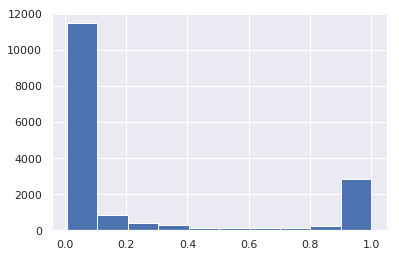

In [237]:
pd.Series(y_pred_prob[:, 1]).hist()

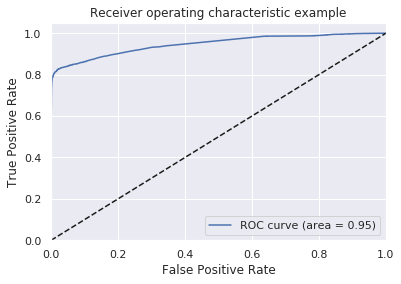

In [206]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [383]:
params = {'criterion': 'entropy',
 'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 16,
 'n_estimators': 20}
clf_rf = RandomForestClassifier(**params)

In [461]:
params = {'criterion': 'entropy',
 'max_depth': 9,
 'min_samples_leaf': 1,
 'min_samples_split': 24,
 'n_estimators': 30}
clf_rf = RandomForestClassifier(**params)

In [467]:
params = {'criterion': 'entropy',
 'max_depth': 9,
 'min_samples_leaf': 1,
 'min_samples_split': 14,
 'n_estimators': 20}
clf_rf = RandomForestClassifier(**params)

In [468]:
clf_rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=14,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [469]:
X_test = pd.read_csv('X_test.csv', index_col=0)

In [470]:
X_test.head()

,discovered,passed,started_attempt,viewed,correct,wrong,steps_tried,correct_ratio,unique_days
user_id,,,,,,,,,
4,1,1,0,1,0.0,0.0,0.0,0.000000,0.0
6,1,1,0,1,0.0,0.0,0.0,0.000000,0.0
10,2,2,0,6,0.0,0.0,0.0,0.000000,0.0
12,11,9,4,14,1.0,0.0,1.0,1.000000,1.0
13,70,70,35,105,29.0,36.0,29.0,0.446154,2.0


In [471]:
X_test = X_test.drop(['correct_ratio'], axis=1)

In [472]:
predictions = clf_rf.predict(X_test)

In [447]:
precision = precision_score(y_test, predictions)

In [448]:
precision

0.9642857142857143

In [449]:
clf_rf.score(X_test, y_test)

0.9513513513513514

In [450]:
recall = recall_score(y_test, predictions)

In [451]:
recall

0.7714285714285715

In [473]:
y_pred_prob = clf_rf.predict_proba(X_test)

In [42]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred_prob[:,1])

0.9468875672767597

In [456]:
roc = 1
for i in range(70):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01)
    clf_rf = RandomForestClassifier(**params)
    clf_rf.fit(X_train, y_train)
    y_pred_prob = clf_rf.predict_proba(X_test)
    score = roc_auc_score(y_test, y_pred_prob[:,1])
    if score < roc:
        roc = score
print(roc)

0.8726953467954346


In [474]:
probs = pd.DataFrame(y_pred_prob[:, 1])

In [475]:
probs = probs.set_index(X_test.index)

In [476]:
probs = probs.rename(columns={0: 'is_gone'})

In [477]:
probs = probs.round(2)

In [478]:
probs.head()

,is_gone
user_id,
4,0.02
6,0.02
10,0.03
12,0.09
13,0.90


In [479]:
probs.to_csv('result.csv')

In [305]:
clf_rf.feature_importances_

array([0.00130498, 0.0702795 , 0.551751  , 0.14620113, 0.01841684,
       0.04589656, 0.13314367, 0.02001203, 0.0129943 ])